# Importing necessary packages

In [1]:
import os
import pickle
from pathlib import Path

import numpy as np
import pandas as pd

from category_encoders import OneHotEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

from hyperopt import Trials, tpe, hp, fmin, space_eval
from hyperopt.pyll import scope

import shap

import warnings
# Ignore all future warnings in Jupyter notebook
warnings.filterwarnings('ignore', category=FutureWarning)
np.random.seed(8)

# Data importing and preperation

In [2]:
df_type='dataset3'
project_path=os.getcwd()

df1_path= os.path.join(project_path,"data/dataset1.csv")
df1 = pd.read_csv(df1_path)
df1.columns=['Cem', 'BFS','FA', 'Water','SP','CAg', 'FAg', 'Age','CS']

df1['W/B'] = df1['Water']/(df1['Cem'] + df1['BFS'] + df1['FA'])
df1['BFS/W'] = df1['BFS']/df1['Water']
df1['FA/W'] = df1['FA']/df1['Water']
df1['CAg/B'] = df1['CAg']/(df1['Cem'] + df1['BFS'] + df1['FA'])
df1['CAg/FAg'] = df1['CAg']/df1['FAg']

df2_path= os.path.join(project_path,"data/dataset2.csv")
df2 = pd.read_csv(df2_path)
df2.columns=['Cmix', 'wc_u','wc_std', 'Vp_u','Pv_std','Yd_u','Yd_std', # Table 1
             'ξg_u','ξg_std','Xog_u','Xog_std','ξp_u','ξp_std','Xop_u','Xop_std','dp_u','dp_std','dpmax_u','dpmax_std','po_u','po_std', # Tabl2
             'φ','h','m','ρ','Fmax','CS']
             

## One Hot Encoding of catergorical variables

In [3]:
# Encoding catergorical data
encoder = OneHotEncoder(cols=['Cmix'], use_cat_names=True)
df2 = pd.concat([df2['Cmix'],encoder.fit_transform(df2)], axis=1)

## Merging two data sets

In [4]:
df3=pd.merge(df1,df2,on='CS', how='outer',indicator=True)
df3['Cmix_merge'] = df3['Cmix'].astype(str) + df3['_merge'].astype(str)
print(df1.shape,df2.shape,df3.shape)

(1030, 14) (527, 30) (1525, 45)


## Getting the correlation of featrues

In [5]:
# Correlation analysis
df3_corr = df3.drop(columns=['Cmix','_merge', 'Cmix_merge']).copy()
df3_corr = df3_corr.corr().round(4)
df3_corr

,Cem,BFS,FA,Water,SP,CAg,FAg,Age,CS,W/B,...,dp_std,dpmax_u,dpmax_std,po_u,po_std,φ,h,m,ρ,Fmax
Cem,1.0000,-0.2469,-0.4130,-0.0964,0.1565,-0.1449,-0.2163,0.0570,0.4833,-0.4919,...,0.0294,-0.1460,-0.0622,0.0495,0.0752,-0.1796,-0.1790,-0.0265,0.0140,-0.1658
BFS,-0.2469,1.0000,-0.3402,0.0915,0.0436,-0.2749,-0.2960,-0.0382,0.1368,-0.3018,...,0.0474,-0.0579,-0.0069,-0.0152,0.0335,-0.0745,-0.0741,0.0433,0.0066,-0.0724
FA,-0.4130,-0.3402,1.0000,-0.2451,0.3106,0.0113,0.1025,-0.1547,-0.1136,-0.0952,...,-0.0906,0.0859,0.0029,-0.0704,-0.1130,0.1642,0.1636,-0.0252,0.0293,0.1568
Water,-0.0964,0.0915,-0.2451,1.0000,-0.6786,-0.1502,-0.4697,0.3315,-0.2741,0.5403,...,-0.0581,0.1479,0.1551,0.0087,0.0333,0.0907,0.0887,0.0360,-0.0522,0.0507
SP,0.1565,0.0436,0.3106,-0.6786,1.0000,-0.2923,0.2513,-0.2343,0.3370,-0.6108,...,0.0620,-0.1577,-0.1495,-0.0080,-0.0089,-0.1083,-0.1054,-0.0078,0.0615,-0.0696
CAg,-0.1449,-0.2749,0.0113,-0.1502,-0.2923,1.0000,-0.1732,0.0024,-0.1610,0.2484,...,-0.0435,0.0229,0.0150,0.1069,0.0453,-0.0219,-0.0267,0.1017,-0.0581,-0.0284
FAg,-0.2163,-0.2960,0.1025,-0.4697,0.2513,-0.1732,1.0000,-0.1916,-0.1686,0.2302,...,0.0711,-0.0546,-0.1111,-0.0794,-0.1135,0.0267,0.0303,-0.0816,0.0729,0.0496
Age,0.0570,-0.0382,-0.1547,0.3315,-0.2343,0.0024,-0.1916,1.0000,0.2990,0.1791,...,0.0780,0.1415,0.0764,0.1482,0.1581,0.0123,0.0142,0.0302,-0.1276,0.0168
CS,0.4833,0.1368,-0.1136,-0.2741,0.3370,-0.1610,-0.1686,0.2990,1.0000,-0.6057,...,0.3556,-0.2576,-0.2647,0.5774,0.4550,-0.4686,-0.4699,0.1769,-0.3627,-0.3687
W/B,-0.4919,-0.3018,-0.0952,0.5403,-0.6108,0.2484,0.2302,0.1791,-0.6057,1.0000,...,-0.0290,0.2012,0.1249,0.0091,-0.0287,0.1836,0.1827,0.0167,-0.0618,0.1557


## Missing value heatmap

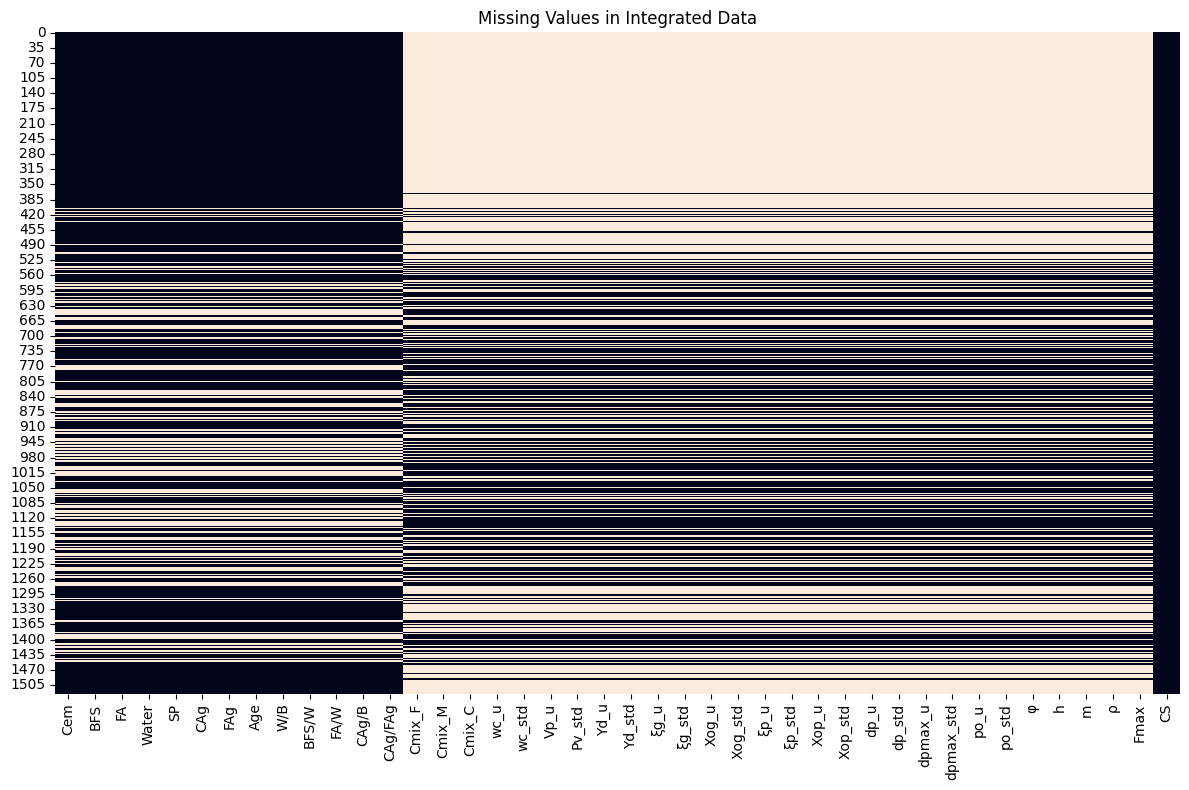

In [6]:

df_missing=df3.drop(columns=['Cmix','_merge', 'Cmix_merge'])
df_missing = df_missing[[col for col in df_missing.columns if col != 'CS'] + ['CS']]
            
plt.figure(figsize=(12, 8))
g=sns.heatmap(df_missing.isnull(), cbar=False)
g.set_xlabel('')
g.set_title('Missing Values in Integrated Data')
# Save the plot
plt.tight_layout()
plt.savefig(f'results/{df_type}Missing_heatmap.png', format='png', dpi=600)
plt.show()


## Data partitioning into training, validation and testing datasets

In [7]:
df3.value_counts('Cmix_merge')

df3=df3.drop(columns=['Cmix','_merge'])
Input_features = df3.columns.drop('CS')

print(Input_features)
X = df3[Input_features]
y = df3['CS']
# Splitting the data into training, temporary test, and validation sets (80%, 10%, 10%) with stratified split based on 'Cmix_merge'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=8, stratify=X['Cmix_merge'])
X_train_wo_valid, X_val, y_train_wo_valid, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=8, stratify=X_train['Cmix_merge'])

# Drop the 'Cmix_merge' column from the datasets
X_train = X_train.drop(columns=['Cmix_merge'])
X_train_wo_valid = X_train_wo_valid.drop(columns=['Cmix_merge'])
X_test = X_test.drop(columns=['Cmix_merge'])
X_val = X_val.drop(columns=['Cmix_merge'])

Index(['Cem', 'BFS', 'FA', 'Water', 'SP', 'CAg', 'FAg', 'Age', 'W/B', 'BFS/W',
       'FA/W', 'CAg/B', 'CAg/FAg', 'Cmix_F', 'Cmix_M', 'Cmix_C', 'wc_u',
       'wc_std', 'Vp_u', 'Pv_std', 'Yd_u', 'Yd_std', 'ξg_u', 'ξg_std', 'Xog_u',
       'Xog_std', 'ξp_u', 'ξp_std', 'Xop_u', 'Xop_std', 'dp_u', 'dp_std',
       'dpmax_u', 'dpmax_std', 'po_u', 'po_std', 'φ', 'h', 'm', 'ρ', 'Fmax',
       'Cmix_merge'],
      dtype='object')


# TPE optimization of xgboost

In [8]:
def objFun(params):
        model = XGBRegressor(**params, random_state=np.random.RandomState(11), n_jobs=-1)
        model.fit(X_train_wo_valid, y_train_wo_valid)    
        predict_val = model.predict(X_val)
        rmse = root_mean_squared_error(y_val, predict_val)
        return rmse
space={'n_estimators': scope.int(hp.quniform('n_estimators', 50, 10000,1)),
        'min_split_loss': scope.float(hp.uniform('min_split_loss', 0.0001, 1.0)),
            'max_depth': scope.int(hp.quniform('max_depth', 2, 7,1)),
            'subsample': scope.float(hp.uniform('subsample', 0.9, 1)),
            'reg_alpha': scope.float(hp.uniform('reg_alpha', 0.01, 1.0)),
            'grow_policy': hp.choice('grow_policy', ['depthwise', 'lossguide']),
            'learning_rate': scope.float(hp.uniform('learning_rate', 0.01, 0.20)),
            'colsample_bylevel': scope.float(hp.uniform('colsample_bylevel', 0.9, 1)),
            'colsample_bytree': scope.float(hp.uniform('colsample_bytree', 0.9, 1)),
        }
trials = Trials()
rng = np.random.default_rng(11)
best = fmin(fn=objFun,
            space=space,
            algo=tpe.suggest,
            max_evals=500,
            trials=trials,
            rstate=rng)
xgb_best=best
best_hyperparams =  space_eval(space, xgb_best)   
best_hyperparams.update({'RMSE': trials.best_trial['result']['loss']})
pd.DataFrame.from_dict([best_hyperparams]).to_csv(f'results/{df_type}_best_hyperparams.csv', index=False)

100%|██████████| 500/500 [24:54<00:00,  2.99s/trial, best loss: 3.2903163764477634]


In [9]:
with open( f'results/{df_type}_xgb_traisl.pkl', 'wb') as file:
    pickle.dump(trials, file)
with open(f'results/{df_type}_xgb_best.pkl', 'wb') as file:
    pickle.dump(best, file)

## Comparison with other ML methods

In [10]:
model_list = ['TPE_xgboost','xboost_naïve','RF', 'SVM','ANN']
res_dic = {}
mean_imputer = SimpleImputer(strategy='mean')
for idx, model_name in enumerate(model_list):
    if model_name == 'TPE_xgboost':
        df_best_hyperparams=pd.read_csv(f'results/{df_type}_best_hyperparams.csv')
        model = XGBRegressor(n_estimators=df_best_hyperparams['n_estimators'].values[0],
                            max_depth=df_best_hyperparams['max_depth'].values[0],
                            min_split_loss=df_best_hyperparams['min_split_loss'].values[0],
                            reg_alpha=df_best_hyperparams['reg_alpha'].values[0],
                            grow_policy=df_best_hyperparams['grow_policy'].values[0],
                            colsample_bylevel=df_best_hyperparams['colsample_bylevel'].values[0],
                            colsample_bytree=df_best_hyperparams['colsample_bytree'].values[0],
                            learning_rate=df_best_hyperparams['learning_rate'].values[0],
                            subsample=df_best_hyperparams['subsample'].values[0],
                            random_state=2,
                            n_jobs=-1)
        model.fit(X_train, y_train)
        # Save the trained model
        xgb_opt_path = f'results/{df_type}_xgb_opt.pkl'
        with open(xgb_opt_path, 'wb') as file:
            pickle.dump(model, file)
    elif model_name == 'xboost_naïve':
        model =  XGBRegressor(random_state=8)
        model.fit(X_train, y_train)
    elif model_name == 'RF':
        model = Pipeline(steps=[('imputer', mean_imputer),('regressor', RandomForestRegressor(random_state=8))])
        model.fit(X_train, y_train)
    elif model_name == 'SVM':
        model = Pipeline(steps=[('imputer', mean_imputer),('regressor', SVR(kernel='rbf'))])
        model.fit(X_train, y_train)
    elif model_name == 'ANN':
        model = Pipeline(steps=[('imputer', mean_imputer),('regressor', MLPRegressor(random_state=8))])
        model.fit(X_train, y_train)
    predictions_train = model.predict(X_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))
    r2_train = r2_score(y_train, predictions_train)
    mae_train = mean_absolute_error(y_train, predictions_train)
    predictions_val = model.predict(X_val)
    rmse_val = np.sqrt(mean_squared_error(y_val, predictions_val))
    r2_val = r2_score(y_val, predictions_val)
    mae_val = mean_absolute_error(y_val, predictions_val)
    predictions_test = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))
    r2_test = r2_score(y_test, predictions_test)
    mae_test = mean_absolute_error(y_test, predictions_test)
    res_dic[f'{model_name}'] = {'RMSE_training': rmse_train,
                                'RMSE_validation': rmse_val,
                                'RMSE_testing': rmse_test,
                                'R2_training': r2_train,
                                'R2_validation': r2_val,
                                'R2_testing': r2_test,
                                'MAE_training': mae_train,
                                'MAE_validation': mae_val,
                                'MAE_testing': mae_test}
results_df=pd.DataFrame.from_dict(res_dic)
results_df

,TPE_xgboost,xboost_naïve,RF,SVM,ANN
RMSE_training,0.648860,0.851971,1.459343,14.365196,8.496719
RMSE_validation,0.705212,0.731579,1.719924,15.114504,9.119989
RMSE_testing,3.441819,3.473262,4.347431,14.237811,8.880854
R2_training,0.998042,0.996624,0.990093,0.040072,0.664171
R2_validation,0.997896,0.997736,0.987488,0.033739,0.648201
R2_testing,0.942377,0.941319,0.908063,0.013927,0.616353
MAE_training,0.353957,0.476244,0.864234,10.855834,6.536963
MAE_validation,0.376173,0.435303,0.934146,11.493709,6.895162
MAE_testing,2.124258,2.131231,2.498373,10.482029,6.839863


In [11]:
results_df.to_csv(f'results/{df_type}results.csv')

## Ploting optimizaiton resusts

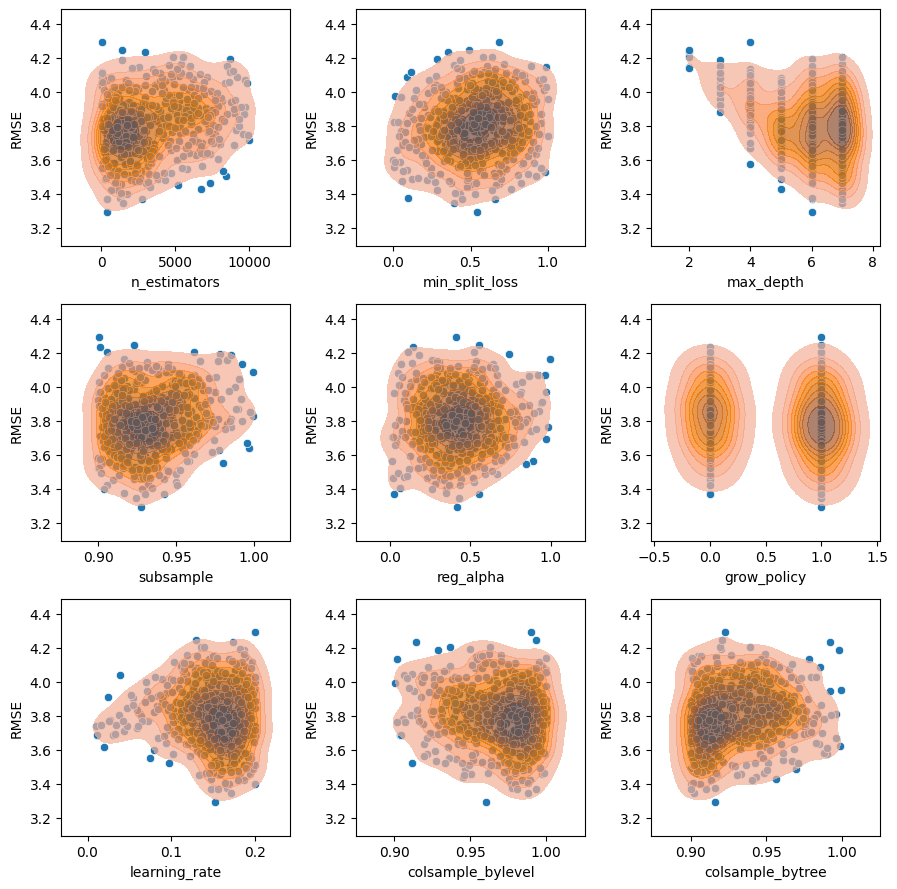

In [12]:
with open( f'results/{df_type}_xgb_traisl.pkl', 'rb') as file:
    trials = pickle.load(file)
with open(f'results/{df_type}_xgb_best.pkl', 'rb') as file:
    xgb_best = pickle.load(file)

losses = [trial['result']['loss'] for trial in trials.trials]
q3 = np.percentile(losses, 75)
upper_bound = q3 + 1.5 * (q3 - np.percentile(losses, 25))
filtered_trials = [trial for trial in trials.trials if trial['result']['loss'] <= upper_bound]

df_trials = pd.DataFrame([{**{k: v[0] for k, v in trial['misc']['vals'].items()}, 'loss': trial['result']['loss']} for trial in filtered_trials])
hyperparameters = ['n_estimators', 'min_split_loss', 'max_depth', 'subsample', 'reg_alpha', 'grow_policy',
                   'learning_rate', 'colsample_bylevel', 'colsample_bytree']
fig, axes = plt.subplots(3, 3, figsize=(9, 9))
axes = axes.flatten()
min_loss_index = df_trials['loss'].idxmin()
for i, hyperparam in enumerate(hyperparameters):
    ax = axes[i]
    sns.scatterplot(x=hyperparam, y='loss', data=df_trials, ax=ax)
    sns.kdeplot(y='loss',data=df_trials, x=hyperparam, ax=ax, fill=True, alpha=.7)
    ax.set_xlabel(hyperparam)
    ax.set_ylabel('RMSE')
    best_hyperparam_value = df_trials.loc[min_loss_index, hyperparam]
    best_loss = df_trials.loc[min_loss_index, 'loss']
plt.tight_layout()
plt.savefig(f'results/{df_type}_trailsvsloss.svg', format='svg')
plt.savefig(f'results/{df_type}_trailsvsloss.png', format='png')
plt.show()
plt.close()

In [13]:
# Load the saved model
with open(xgb_opt_path, 'rb') as file:
    model = pickle.load(file)

## Plotting the diagnostic curves

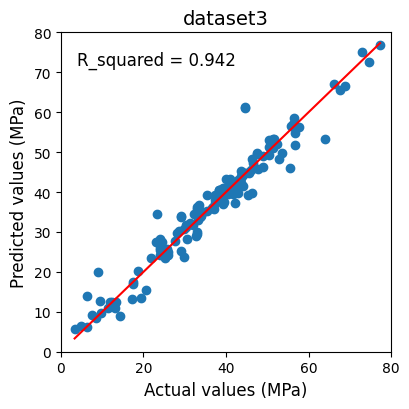

In [14]:
plt.figure(figsize=(4.2, 4.2))
plt.scatter(y_test, model.predict(X_test))
plt.xlabel('Actual values (MPa)', fontsize=12)
plt.ylabel('Predicted values (MPa)', fontsize=12)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.annotate(f"R_squared = {results_df['TPE_xgboost']['R2_testing']:.3f}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)
plt.title('dataset3', fontsize=14)
plt.ylim([0, 80])  # Set the y-axis limits to -10 and 10
plt.xlim([0, 80]) 
plt.tight_layout()

plt.savefig(f'results/{df_type}_predvsact.svg', format='svg',dpi=600)
plt.savefig(f'results/{df_type}_predvsact.png', format='png',dpi=600)
plt.show()

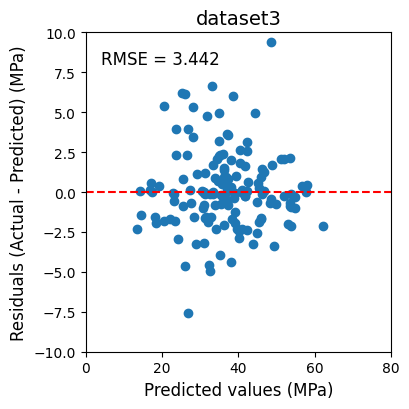

In [15]:
plt.figure(figsize=(4.2, 4.2))
residuals = y_test - model.predict(X_test)
plt.scatter(predictions_test, residuals)
plt.xlabel('Predicted values (MPa)', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted) (MPa)', fontsize=12)
plt.axhline(y=0, color='red', linestyle='--')
plt.annotate(f"RMSE = {results_df['TPE_xgboost']['RMSE_testing']:.3f}", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=12)
plt.title('dataset3', fontsize=14)
plt.ylim([-10, 10])  # Set the y-axis limits to -10 and 10
plt.xlim([0, 80]) 
plt.tight_layout()

plt.savefig(f'results/{df_type}_residualvspred.svg', format='svg', dpi=600)
plt.savefig(f'results/{df_type}_residualvspred.png', format='png',dpi=600)
plt.show()

# Explainability analyses and results

In [16]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9601955255926204, colsample_bynode=None,
             colsample_bytree=0.915929283327945, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy='lossguide',
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1515158790400385, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, min_split_loss=0.5402106939904845,
             missing=nan, monotone_constraints=None, n_estimators=360,
             n_jobs=-1, num_parallel_tree=None, predictor=None, ...)

In [17]:
df_exp = X_test[X_test.columns]
explainer = shap.TreeExplainer(model)
shap_values = explainer(df_exp)

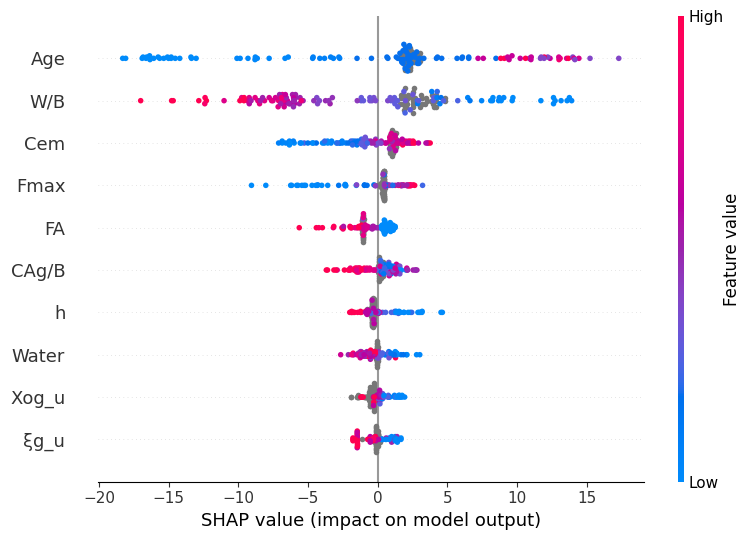

In [18]:
%matplotlib inline 

plt.figure()
shap.summary_plot(shap_values, df_exp, feature_names=df_exp.columns, max_display=10, show=False)
plt.savefig(f'results/{df_type}_shapfeatimp.svg', format='svg', dpi=600, bbox_inches='tight')
plt.savefig(f'results/{df_type}_shapfeatimp.png', format='png', dpi=600, bbox_inches='tight')
plt.show()  
plt.close()  

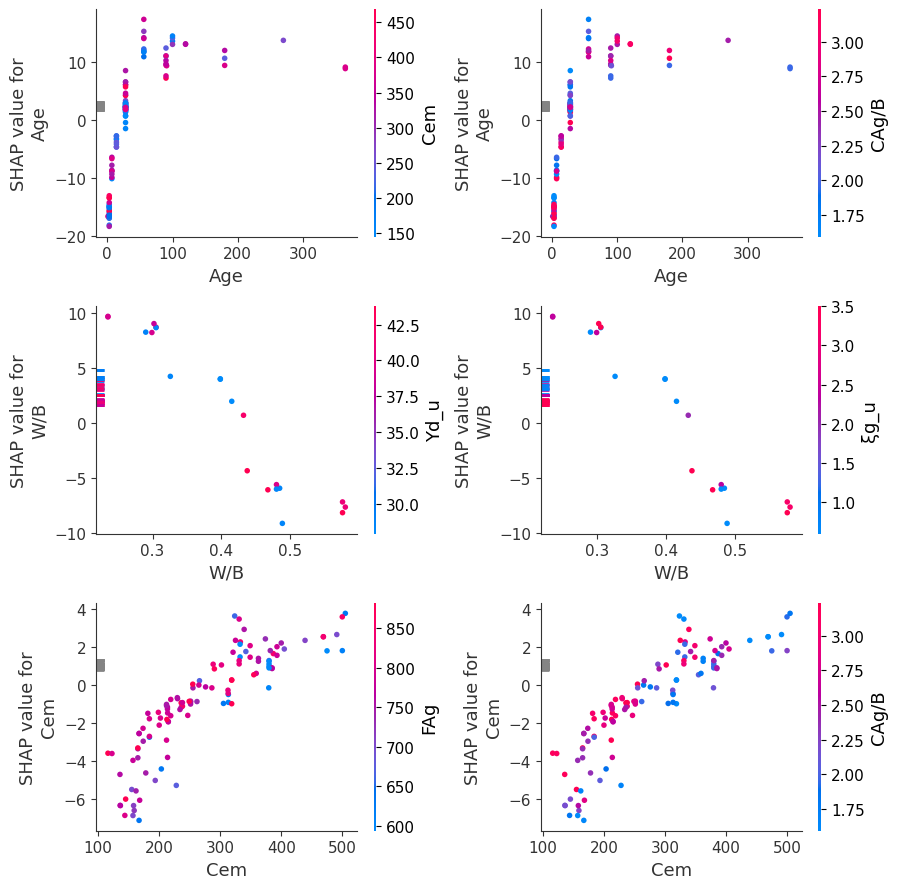

In [19]:
# Use the inline backend for Jupyter
%matplotlib inline 
shap_values = explainer.shap_values(X_test[X_test.columns])
top_3_features= ["Age","W/B","Cem"]
fig, axes = plt.subplots(len(top_3_features), 2, figsize=(9, 9))
for feat_level, feat in enumerate(top_3_features):
    # print(f'{feat_level}:{feat}')
    inds = shap.approximate_interactions(feat, shap_values, df_exp)
    # print(inds)
    # shap.dependence_plot(feat, shap_values, X_test, interaction_index=inds[i])
    for i in range(2):
        ax = axes[feat_level, i]
        # plt.subplot(len(top_3_features), 2, feat_level * 2 + (i + 1))  # Specify subplot position
        shap.dependence_plot(feat, shap_values, X_test, interaction_index=inds[i], ax=ax, show=False) 
        # shap.dependence_plot(feat, shap_values, X_test, interaction_index=inds[i],ax=ax)
plt.tight_layout()
plt.savefig(f'results/{df_type}_all_interactions.svg', format='svg', dpi=600, bbox_inches='tight')
plt.show()
plt.close()

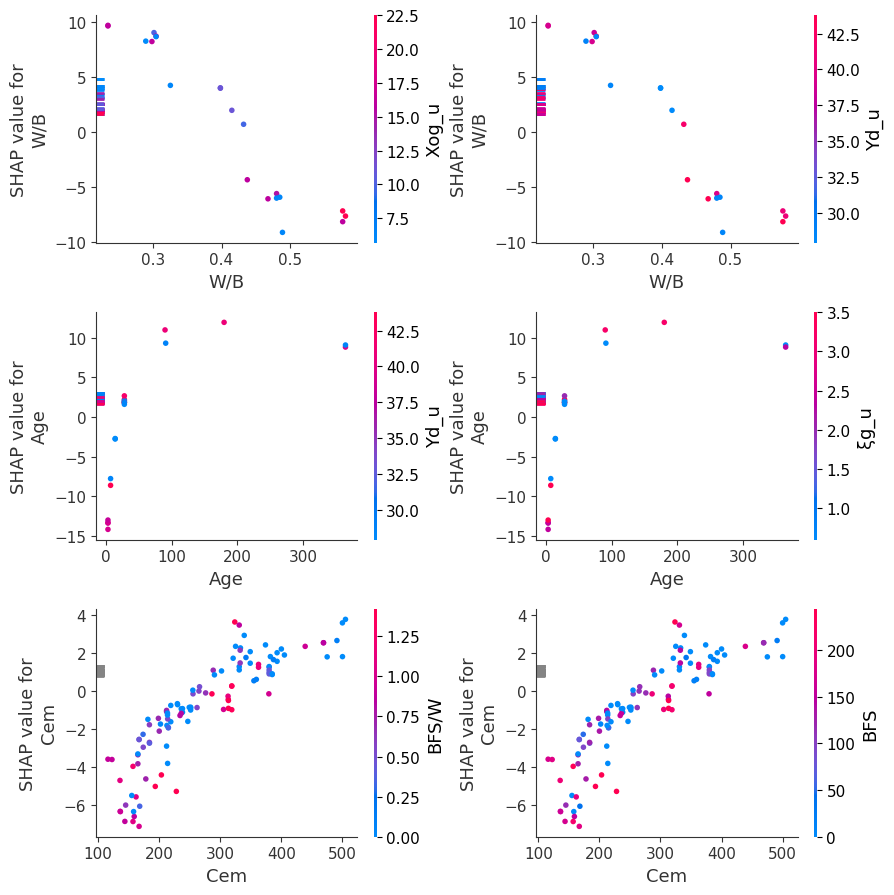

In [20]:
%matplotlib inline 
import matplotlib.pyplot as plt
import shap

shap_values = explainer.shap_values(X_test[X_test.columns])
fig, axes = plt.subplots(3, 2, figsize=(9, 9))

dic_of_feats = {
    "W/B": ["Xog_u", "Yd_u"],
    "Age": ["Yd_u", "ξg_u"],
    "Cem": ["BFS/W", "BFS"]
}

for key_in, (key, values) in enumerate(dic_of_feats.items()):
    value_in = 0
    for value in values:
        ax = axes[key_in, value_in]
        shap.dependence_plot(key, shap_values, X_test, interaction_index=value, ax=ax, show=False)
        value_in += 1

plt.tight_layout()
plt.show()
plt.close()